# Token Replay Prototyping

In [39]:
from collections import defaultdict
%reload_ext autoreload
%autoreload 2

import pm4py
import random
from practical.ProcessMining.group1.shared.visualizer import Visualizer
from practical.ProcessMining.group1.shared.utils import event_log_to_dataframe, read_txt_test_logs, event_log_to_csv
from practical.ProcessMining.group1.task2.alphaminer import AlphaMiner
from practical.ProcessMining.group1.task3.inductiveminer import InductiveMiner
from practical.ProcessMining.group1.task3.inductiveminer_infrequent import InductiveMinerInfrequent

logs = read_txt_test_logs("../shared/example_files/simple_event_logs.txt")
LOG_KEY="L2"

vizard = Visualizer()

## Visualization Test

In [40]:
def mock_missing_remaining_tokens(places):
    tokens = {"missing": defaultdict(), "remaining": defaultdict()}
    middle_places = [p for p in places if p != "start" and p != "end"]
    for place in random.sample(middle_places, len(middle_places)//2):
        tokens["missing"][place] = random.randint(1, 10)
    for place in random.sample(middle_places, len(middle_places)//2):
        tokens["remaining"][place] = random.randint(1, 10)
    return tokens

### PM4PY

In [41]:
log = logs[LOG_KEY]
log = event_log_to_dataframe(log)
log = pm4py.format_dataframe(log, case_id='case_id', activity_key='activity', timestamp_key='timestamp')

In [42]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)
places = net.places

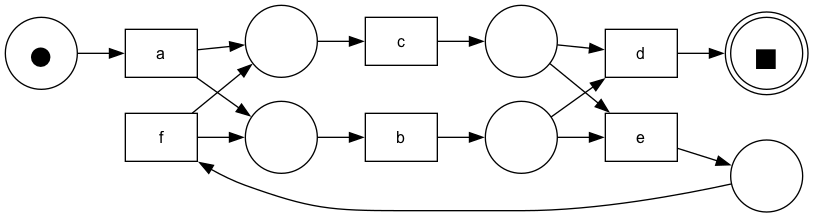

In [43]:
vizard.display(vizard.build_petri_net(net, initial_marking, final_marking))

In [44]:
missing_remaining_tokens = mock_missing_remaining_tokens(places)
missing_remaining_tokens

{'missing': defaultdict(None,
             {({'c'}, {'d', 'e'}): 10, ({'f', 'a'}, {'b'}): 3, start: 10}),
 'remaining': defaultdict(None,
             {({'b'}, {'d', 'e'}): 5, end: 5, ({'f', 'a'}, {'b'}): 10})}

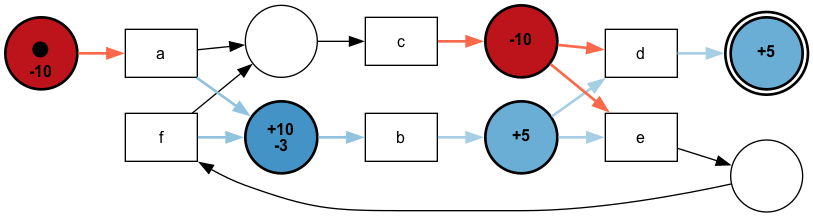

In [45]:
graph_fitness = vizard.build_petri_net(net, initial_marking, final_marking, missing_remaining_tokens)
vizard.display(graph_fitness)

### Task2 Alpha Miner

In [46]:
miner = AlphaMiner(event_log_to_csv(logs[LOG_KEY]))
graph = miner.build_and_visualize_petrinet()

net, initial_marking, final_marking = miner.get_petrinet()
places = net.places

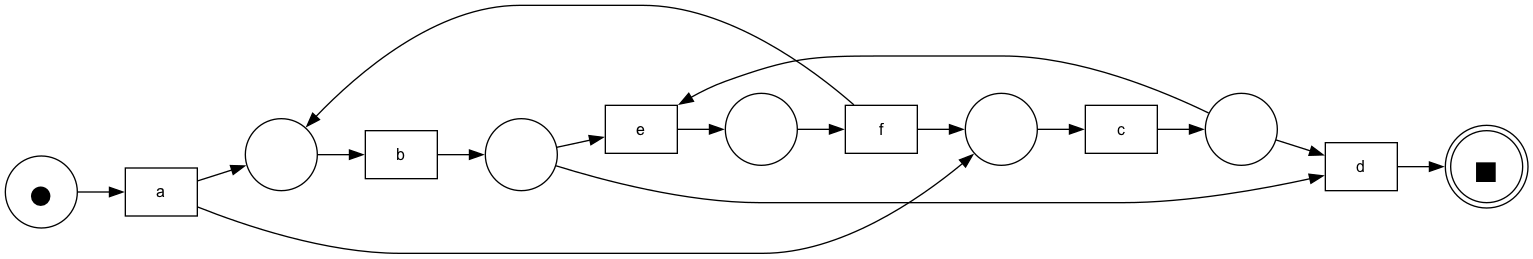

In [47]:
vizard.display(graph)

In [48]:
missing_remaining_tokens = mock_missing_remaining_tokens(places)
missing_remaining_tokens

{'missing': defaultdict(None,
             {p({'b'}, {'d', 'e'}): 2,
              p({'f', 'a'}, {'b'}): 7,
              p({'e'}, {'f'}): 2}),
 'remaining': defaultdict(None,
             {p({'c'}, {'d', 'e'}): 4,
              global_end: 10,
              p({'f', 'a'}, {'b'}): 2})}

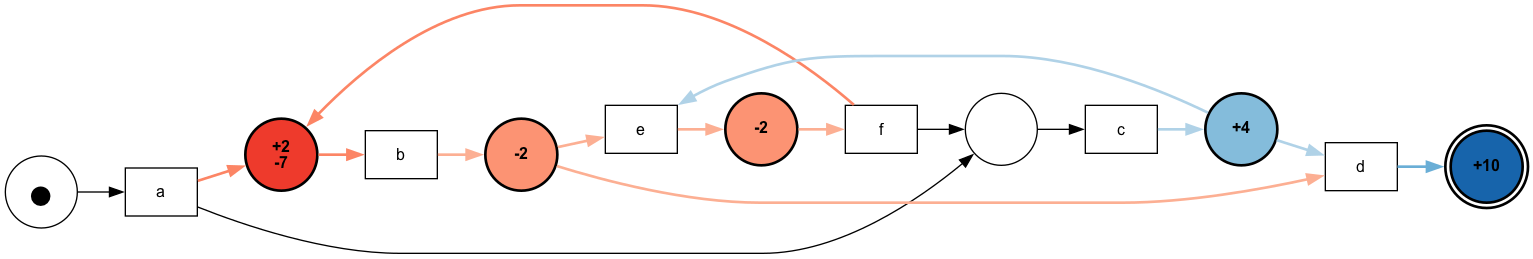

In [49]:
graph_fitness = vizard.build_petri_net(net, initial_marking, final_marking, missing_remaining_tokens)
vizard.display(graph_fitness)

### Task3 Inductive Miner

In [50]:
log = logs[LOG_KEY]
miner = InductiveMiner(log)
miner.run()
graph = miner.build_and_visualize_petrinet()

net, initial_marking, final_marking = miner.get_petrinet()
places = net.places

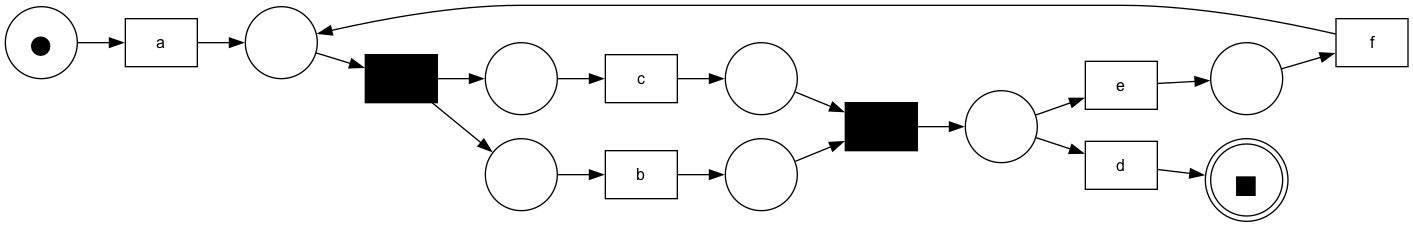

In [51]:
vizard.display(graph)

In [52]:
missing_remaining_tokens = mock_missing_remaining_tokens(places)
missing_remaining_tokens

{'missing': defaultdict(None, {p_9: 7, p_12: 1, p_6: 7, p_10: 7}),
 'remaining': defaultdict(None, {sink: 6, p_9: 4, p_5: 7, p_10: 1})}

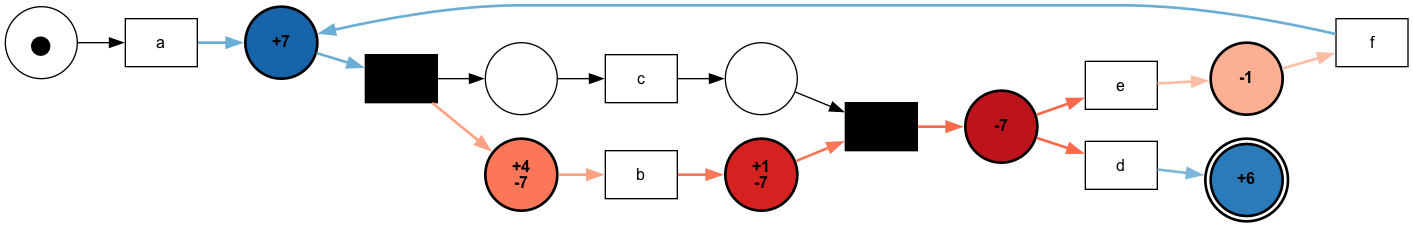

In [53]:
graph_fitness = vizard.build_petri_net(net, initial_marking, final_marking, missing_remaining_tokens)
vizard.display(graph_fitness)

In [54]:
log = logs[LOG_KEY]
miner = InductiveMinerInfrequent(log)
miner.run()
graph = miner.build_and_visualize_petrinet()

net, initial_marking, final_marking = miner.get_petrinet()
places = net.places

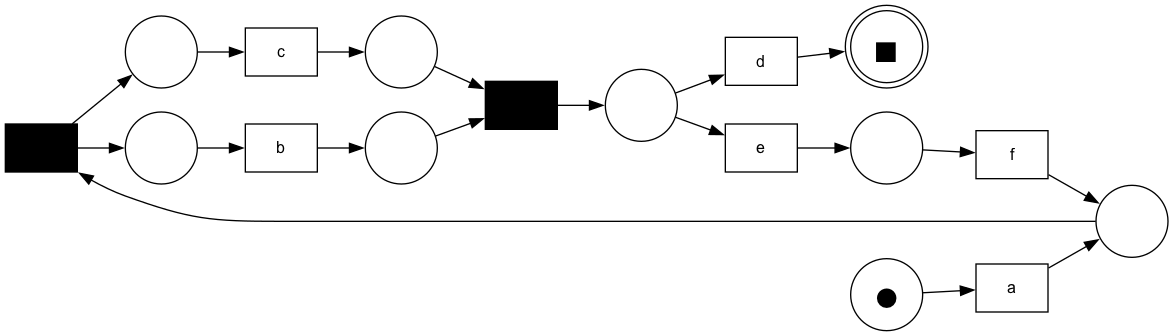

In [55]:
vizard.display(graph)

In [56]:
missing_remaining_tokens = mock_missing_remaining_tokens(places)
missing_remaining_tokens

{'missing': defaultdict(None, {p_10: 3, p_8: 9, p_9: 7, p_5: 3}),
 'remaining': defaultdict(None, {p_8: 4, p_7: 4, p_12: 8, p_5: 6})}

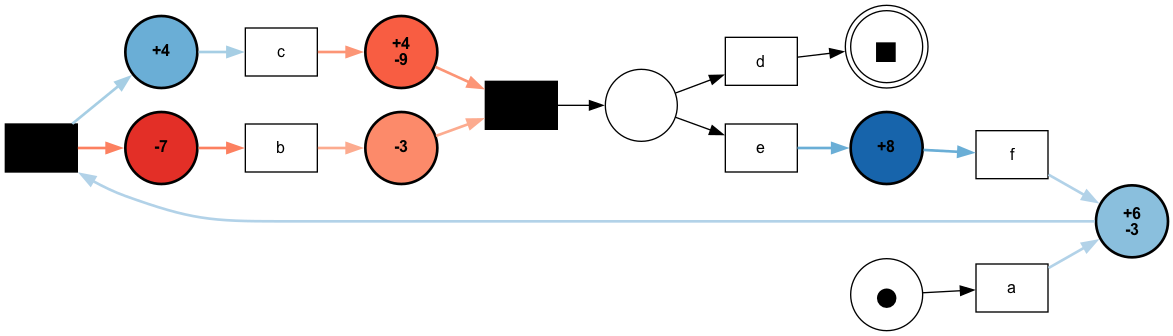

In [57]:
graph_fitness = vizard.build_petri_net(net, initial_marking, final_marking, missing_remaining_tokens)    
vizard.display(graph_fitness)

In [ ]:
from practical.ProcessMining.group1.shared import utils
from practical.ProcessMining.group1.shared.visualizer import Visualizer
from practical.ProcessMining.group1.task4.tokenreplay import TokenReplay
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.objects.conversion.log import converter as log_converter

BASE = utils.SAMPLES_PATH

text_logs = str(BASE / 'simple_event_logs.txt')
text_logs2 = str(BASE / 'simple_event_logs_modified.txt')


def get_log(path):
    logs = utils.read_txt_test_logs(path)
    log = logs['L1']
    log = utils.event_log_to_pm4py_dataframe(log)
    return log_converter.to_event_log.apply(log)
    
log_org = get_log(text_logs)
log_mod = get_log(text_logs2)

# Alpha Miner
alpha_net, alpha_initial_marking, alpha_final_marking = alpha_miner.apply(log_org)

alpha_token_replay = TokenReplay(log_mod, alpha_net, alpha_initial_marking, alpha_final_marking, "Alpha Miner")
alpha_token_replay.run()
tokens = alpha_token_replay.get_unconformity_tokens()

vizard = Visualizer()
graph_fitness = vizard.build_petri_net(alpha_net, alpha_initial_marking, alpha_final_marking, tokens)
vizard.save(graph_fitness, 'graph_fitness2')